## Import libraries

In [1]:
from earthai.init import *

import geopandas as gpd
import folium
import folium.plugins
import earthai.chipping.strategy
import pyspark.sql.functions as F


Importing EarthAI libraries.
EarthAI version 1.4.0; RasterFrames version 0.9.0.dev+astraea.1ce1ff3; PySpark version 2.4.4

Creating SparkSession...
  SparkSession is available as `spark`.


## The STEP data set

In this notebook, we are going to read in a vector file and use it to read in raster data. The vector file we will use is the land use / land cover labelled dataset from the System for Terrestrial Ecosystem Parameterization (STEP). This dataset includes land cover classifications for 1,983 labelled regions that was collected from very high resolution imagery in 2014. The labelled sites range from 1 to 200 square km in size, and are selected for long term stability of land cover / land use. 

There are 17 land cover classes in this dataset. These classes come from the International Geosphere-Biosphere Programme (IGBP), which has detailed descriptions of each land cover type.

| IGBP Class  |  Land Cover Desription  |
|---|---|
| 1 | Evergreen needleleaf forest |
| 2 | Evergreen broadleaf forest |
| 3 | Deciduous needleleaf forest |
| 4 | Deciduous broadleaf forest |
| 5 | Mixed forest |
| 6 | Closed shrubland |
| 7 | Open shrubland |
| 8 | Woody savanna |
| 9 | Savanna |
| 10 | Grassland |
| 11 | Permanent wetland |
| 12 | Cropland |
| 13 | Urban |
| 14 | Cropland and natural vegetation mosaic |
| 15 | Snow and ice |
| 16 | Barren |
| 17 | Water |

## Read and display STEP data set

The STEP data is stored in a GeoJSON file within the Github repo. The code below will read it into a GeoPandas GeoDataFrame.

In [2]:
step_df = gpd.read_file("../data/step_september152014_70rndsel_igbpcl.geojson")

In this example, we are only going to use a subset of this data containing just urban classes so we can quickly explore the data.

In [3]:
step_subset_df = step_df[step_df.igbp.isin([13])]
len(step_subset_df)

104

To see the distribution of urban sites, you can view them on a basemap using folium. 

In [4]:
m = folium.Map(location=[step_subset_df.geometry.centroid.y.mean(), 
                         step_subset_df.geometry.centroid.x.mean()],
               zoom_start=2)

for idx, row in step_subset_df.iterrows():
    folium.Marker([row.geometry.centroid.y, row.geometry.centroid.x], 
                  icon=folium.Icon(color='red', prefix='fa', icon='circle')).add_to(m)
m

## Query and load imagery at STEP sites

To obtain imagery for each STEP site, you can pass the STEP site polygons in the `geometry` column of the `step_subset_df` GeoDataFrame to the `read_catalog` function. The `read_catalog` function returns a GeoDataFrame with a filepath to each image that meets your query parameters. In the query below, we are going to request Landsat-8 imagery for the month of June 2014 with a max of 10% cloud cover over our STEP sites.

In [5]:
catalog = earth_ondemand.read_catalog(
    step_subset_df.geometry,
    start_datetime='2014-06-01', 
    end_datetime='2014-06-30',
    max_cloud_cover=10,
    collections='landsat8_l1tp'
)

100%|██████████| 111/111 [00:03<00:00, 34.92it/s]


We can join the imagery catalog back the STEP data to attach the STEP fields to the imagery data.

In [6]:
step_catalog = gpd.sjoin(step_subset_df, catalog)

The following function will return the band names and descriptions for Landsat-8, so you can select which bands you want to read.

In [7]:
earth_ondemand.bands('landsat8_l1tp')

,band_name,eo_common_name,eo_gsd,title,type,collection_id,roles
0,B5,nir,30.0,Band 5 - Near Infrared (NIR) - 851-879nm (30m),image/tiff,landsat8_l1tp,NaN
1,thumb_large,NaN,NaN,Thumbnail - Large,image/jpeg,landsat8_l1tp,[overview]
2,thumb_small,NaN,NaN,Thumbnail - Small,image/jpeg,landsat8_l1tp,[thumbnail]
3,B9,cirrus,30.0,Band 9 - Cirrus - 1363-1384nm (30m),image/tiff,landsat8_l1tp,NaN
4,B6,swir16,30.0,Band 6 - Shortwave Infrared (SWIR) 1 - 1566-1651nm (30m),image/tiff,landsat8_l1tp,NaN
5,B3,green,30.0,Band 3 - Green - 533-590nm (30m),image/tiff,landsat8_l1tp,NaN
6,B7,swir22,30.0,Band 7 - Shortwave Infrared (SWIR) 2 - 2107-2294nm (30m),image/tiff,landsat8_l1tp,NaN
7,B10,lwir11,30.0,Band 10 - Thermal Infrared (TIRS) 1 - 10600-11190nm (30m),image/tiff,landsat8_l1tp,NaN
8,B2,blue,30.0,Band 2 - Blue - 452-512nm (30m),image/tiff,landsat8_l1tp,NaN
9,BQA,NaN,30.0,Band QA,image/tiff,landsat8_l1tp,NaN


## Raster Reader

There are two main functions for reading in the imagery data: raster reader and chip reader. 

`spark.read.raster` will read in entire scenes of imagery broken up into a gridded set of tiles. Each row in the Spark DataFrame that is returned from `spark.read.raster` will have a set tiles of approximately 256x256 pixels for the bands selected. 

On the other hand, if you have a vector file containing small polygons across large areas (such as the STEP data) and you don't want to read entire scenes, you can pass a list of geometries to `spark.read.chip` and it will read in only the tiles that intersects with one of your geometries. 

Below we are using `spark.read.raster` to read in the red, green, and blue bands. There are over 100k tiles because we are reading entire scenes. You can see the dimensions are all 256x256 pixels and the extent is shifting right across the top row of the same scene. 

Image scenes can be very large, which will slow down data processing, but if you want imagery covering a large area, then it makes sense to use the raster reader.

In [8]:
raster_rf = spark.read.raster(step_catalog, ['B4', 'B3', 'B2']) \
        .withColumnRenamed('B4', 'red') \
        .withColumnRenamed('B3', 'green') \
        .withColumnRenamed('B2', 'blue') \
        .filter(rf_tile_max('red') > 0)

In [9]:
raster_rf.count()

102771

igbp,red,green,blue,rf_dimensions(blue),rf_extent(blue),rf_crs(blue)
13,,,,"[256, 256]","[316965.0, 4735035.0, 324645.0, 4742715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[256, 256]","[324645.0, 4735035.0, 332325.0, 4742715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[256, 256]","[332325.0, 4735035.0, 340005.0, 4742715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[256, 256]","[340005.0, 4735035.0, 347685.0, 4742715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[256, 256]","[347685.0, 4735035.0, 355365.0, 4742715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]

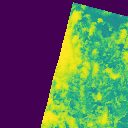
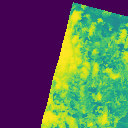
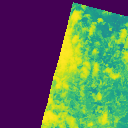
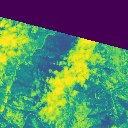
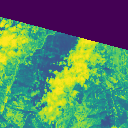
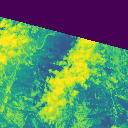
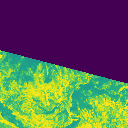
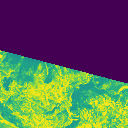
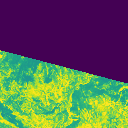
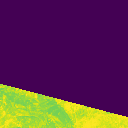
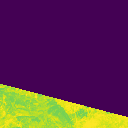
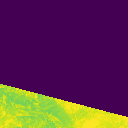
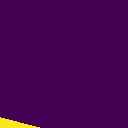
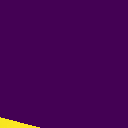
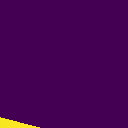

In [10]:
raster_rf.select('igbp', 'red', 'green', 'blue', rf_dimensions('blue'), rf_extent('blue'), rf_crs('blue'))

## Chip Reader

Below we are using `spark.read.chip` to read in the red, green, and blue bands. Less than 100 tiles are returned since we are only reading the tiles that intersect the STEP site geometries. The number of tiles is less the number of urban sites because we set the cloud filter of the Landsat-8 images to 10%. 

The dimensions of each tile varies because the size of the geometries of each urban site are different. You can see from the CRS that the UTM zones of these tiles are different indicating that we are reading imagery from different scenes. 

When you have small polygons covering a large area, it makes more sense to use the chip reader so you don't end up with a lot of "throwaway" imagery. 

In [11]:
chip_rf = spark.read.chip(step_catalog, ['B4', 'B3', 'B2'], chipping_strategy=earthai.chipping.strategy.IntersectingExtent()) \
        .withColumnRenamed('B4', 'red') \
        .withColumnRenamed('B3', 'green') \
        .withColumnRenamed('B2', 'blue') \
        .filter(rf_tile_max('red') > 0)

In [12]:
chip_rf.count()

98

igbp,red,green,blue,rf_dimensions(blue),rf_extent(blue),rf_crs(blue)
13,,,,"[82, 81]","[774285.0, 4378665.0, 776745.0, 4381095.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[94, 90]","[422145.0, 4506465.0, 424965.0, 4509165.0]",[+proj=utm +zone=12 +datum=WGS84 +units=m +no_defs ]
13,,,,"[84, 70]","[330285.0, 4424475.0, 332805.0, 4426575.0]",[+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs ]
13,,,,"[68, 69]","[714735.0, 3896475.0, 716775.0, 3898545.0]",[+proj=utm +zone=30 +datum=WGS84 +units=m +no_defs ]
13,,,,"[84, 70]","[330285.0, 4424475.0, 332805.0, 4426575.0]",[+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs ]

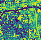
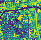
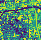
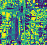
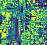
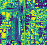
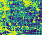
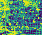
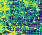
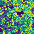
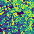
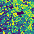
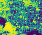
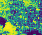
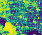

In [13]:
chip_rf.select('igbp', 'red', 'green', 'blue', rf_dimensions('blue'), rf_extent('blue'), rf_crs('blue'))